In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/Bryan/Documents/Programming/Python_Courses/Tensorflow2/DATA/Frozen_Dessert_Production.csv',
                 parse_dates=True, index_col='DATE')
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [3]:
df.columns = ['Production']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
Production    573 non-null float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
# imports

# scale the data
from sklearn.preprocessing import MinMaxScaler

# create the timeseries generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.callbacks import EarlyStopping

import plaidml.keras
plaidml.keras.install_backend()
from keras import backend as K

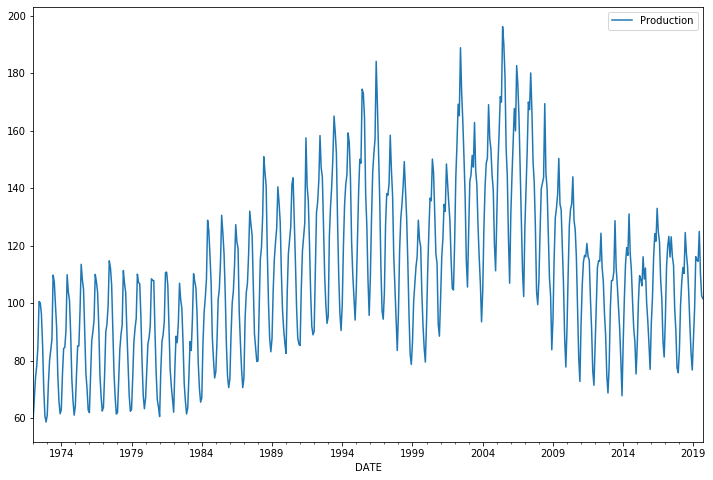

In [5]:
df.plot(figsize=(12,8))

In [6]:
len(df)

573

In [7]:
# pick a cycle of 2 years

test_size = 24
test_ind = len(df) - test_size
test_ind

549

In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
train

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2017-05-01,116.0635
2017-06-01,123.0870
2017-07-01,116.2639


In [10]:
test

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899
2018-03-01,107.3152
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841


In [11]:
len(test)

24

In [12]:
# make an instance of scaler

scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
scaled_train = scaler.transform(train)

scaled_test = scaler.transform(test)

In [17]:
# set batch size shorter than len(test)
# scaled_train is both the source of the X and y

length = 18
n_features = 1

generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=length,

                                batch_size=1)

In [18]:
# make the model
# create the model
# input shape is 18 x 1 (length of batch x n_features)
# tried dropout = 0.2, not much better

model = Sequential()
model.add(LSTM(150,activation='relu', input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [19]:
# set up early stopping

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [20]:
# make the validation generator using the scaled test data for comparison

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [21]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
531/531 [==============================] - 32s 61ms/step - loss: 0.0256 - val_loss: 0.0020
Epoch 2/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0069 - val_loss: 0.0035
Epoch 3/20
531/531 [==============================] - 32s 61ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 4/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 8/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
531/531 [==============================] - 32s 60ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 10/20
531/531 [==============================] - 32s 60ms/step - loss: 0.002

In [22]:
losses = pd.DataFrame(model.history.history)

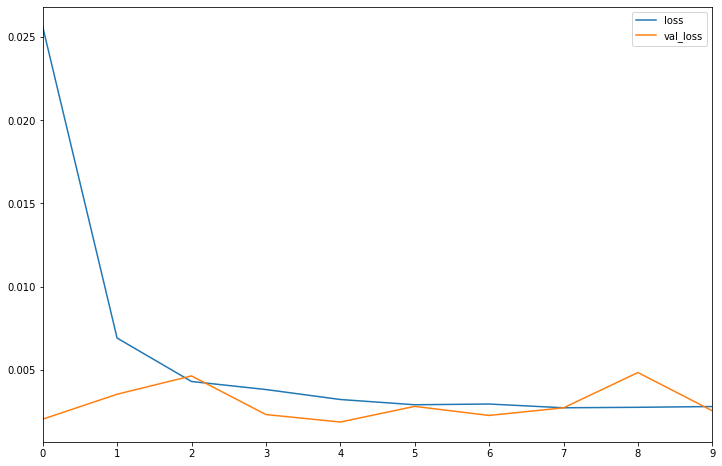

In [23]:
losses.plot(figsize = (12,8))

In [24]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [25]:
# unwind scaling
true_predictions = scaler.inverse_transform(test_predictions)

In [26]:
# create a column in the test df

test['Predictions'] = true_predictions

/Users/Bryan/anaconda/envs/tf2gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,83.599973
2017-11-01,77.4378,72.022123
2017-12-01,75.8118,68.737035
2018-01-01,83.4343,81.173852
2018-02-01,99.4899,93.607852
2018-03-01,107.3152,101.164146
2018-04-01,112.4309,106.408992
2018-05-01,110.3544,110.317682
2018-06-01,124.5841,111.528845


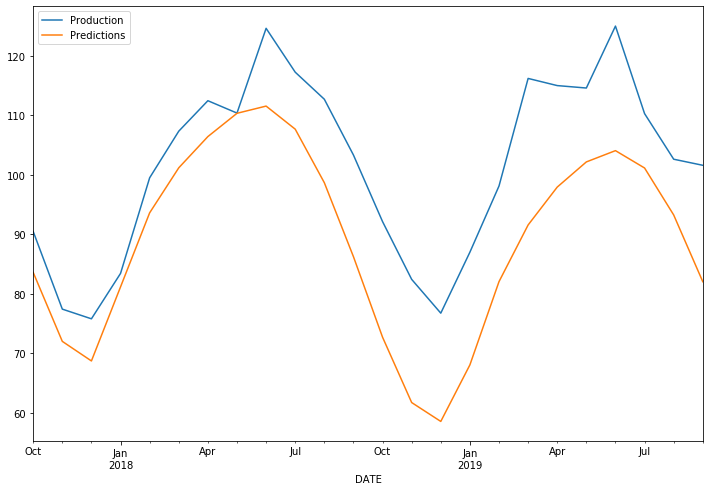

In [28]:
test.plot(figsize=(12,8))

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# get error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

14.114265702981061